# Enhancing Interpretability in Brain Tumor Detection Models through Class Activation Map (CAM) Visualization

## Import Necessary Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import torch.optim as optim
%matplotlib inline


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

To isolate the brain region in the image, we employed a cropping technique that identifies the extreme top, bottom, left, and right points of the brain. You can read more about this method in the PyImageSearch article on  [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [ ]:
def contourAndCrop(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    #TODO:play with parameters and check if it helps with the outputs
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

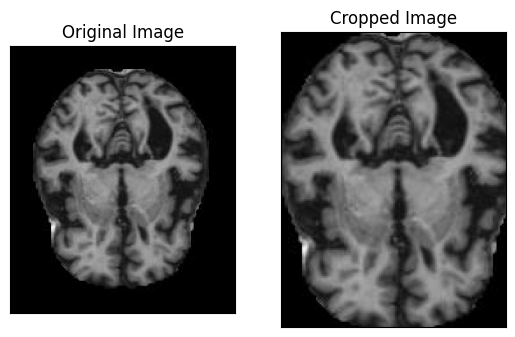

In [ ]:
ex_img = cv2.imread('yes.jpg')
ex_new_img = contourAndCrop(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.


In [ ]:
def load_data_with_unknowns(brain_tumor_dir_list, image_size):
    """
    Load data from both brain tumor and Alzheimer's datasets, and assign labels.
    Arguments:
        brain_tumor_dir_list: List of directories for brain tumor dataset.
        alzheimers_dir_list: List of directories for Alzheimer's dataset.
        image_size: Tuple specifying the desired image size (width, height).
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, #_labels), where each label is multi-label (e.g., [tumor_label]).
    """
    X = []
    y = []
    image_width, image_height = image_size


    for directory in brain_tumor_dir_list:
        for filename in listdir(directory):
            # Load and process the image
            image = cv2.imread(directory + '\\' + filename)
            image = contourAndCrop(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append(1)
            else:  # Tumor is absent
                y.append(0)


    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

# Define directories for brain tumor and Alzheimer's datasets
brain_tumor_yes = 'augmented_data/yes'
brain_tumor_no = 'augmented_data/no'
# alzheimers_yes = 'augmented_data2/yes'
# alzheimers_no = 'augmented_data2/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

# Load data for both brain tumor and Alzheimer's datasets
X, y = load_data_with_unknowns([brain_tumor_yes, brain_tumor_no],  (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065,)


The initial dataset consisted of only 250 images, which was insufficient for training a robust model. To address this, we applied data augmentation techniques to generate additional images and expand the dataset.
link:https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
Now, we load the augmented data from the directory created in the Data Augmentation notebook.
Note: The augmented data directory includes both the newly generated images and the original images.

Additional Note: We tested our code on other datasets to ensure its reliability and robustness, namely:
https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri?resource=download


In [ ]:
augmented_path = 'augmented_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data_with_unknowns([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))
print(y)

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065,)
[1 1 0 ... 1 0 1]


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [ ]:
def plot_(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

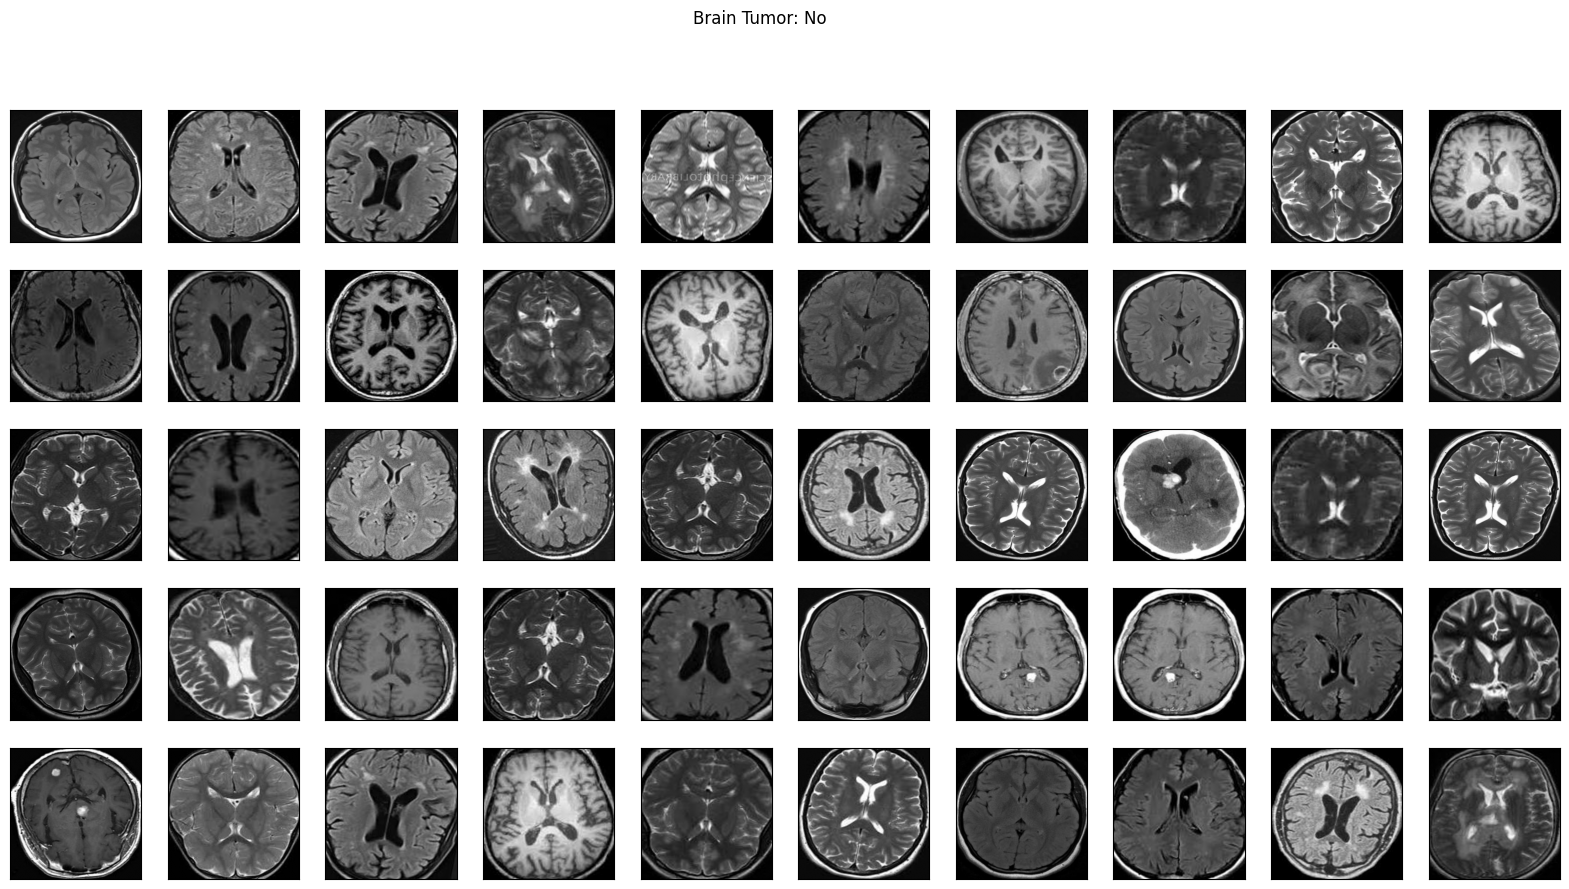

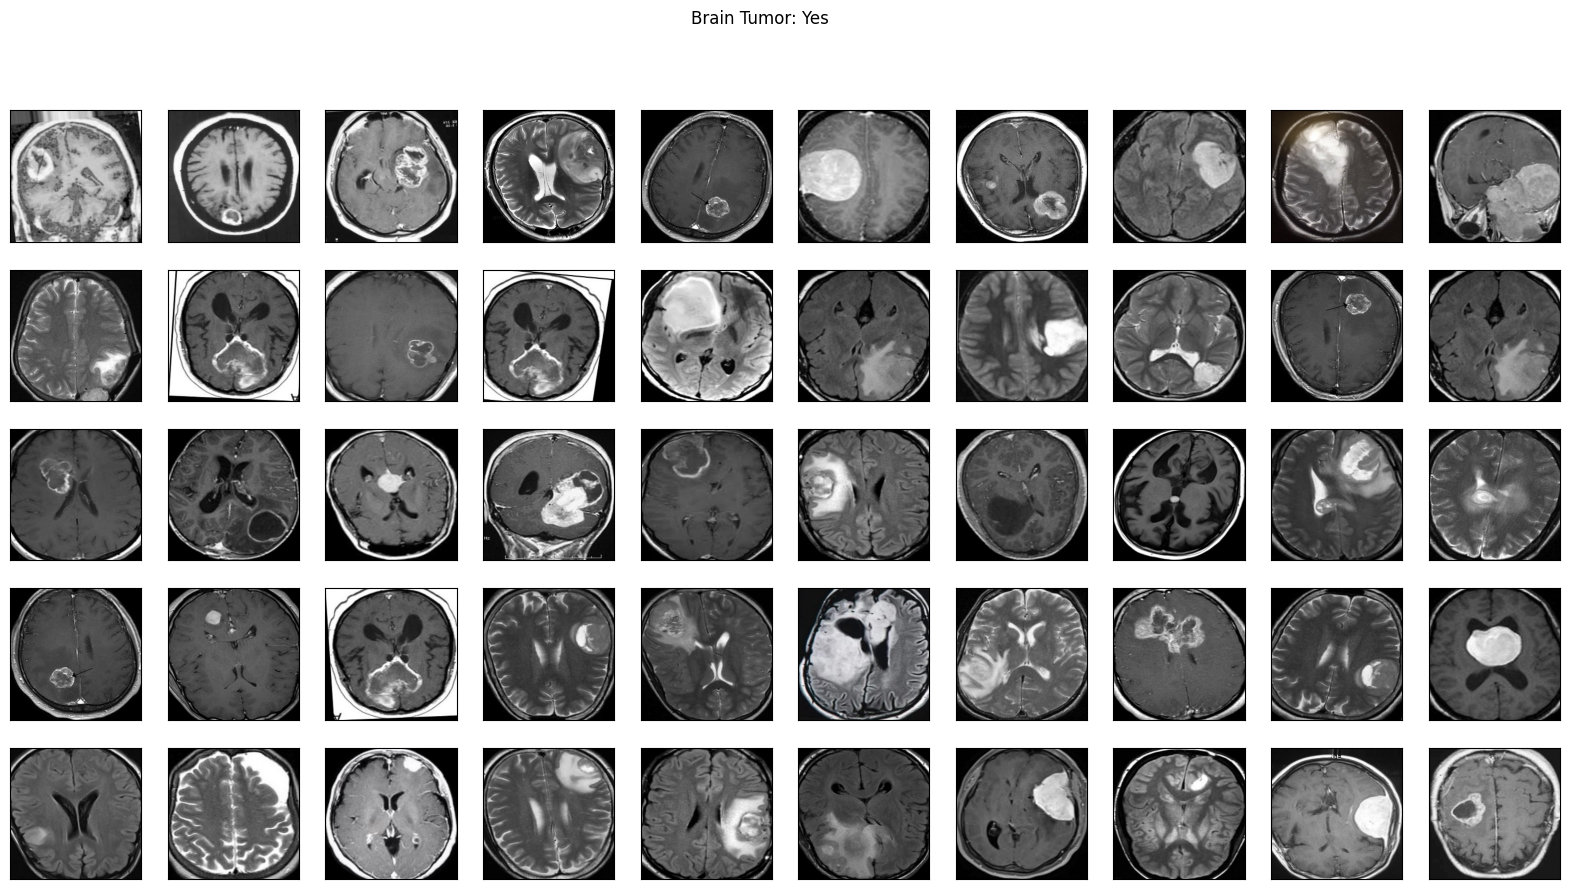

In [ ]:
plot_(X, y)

### Spliting the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [ ]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445,)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310,)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310,)


### Some helper functions:

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class TumorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert to PyTorch tensors
        self.y = torch.tensor(y, dtype=torch.float32)  # Ensure labels are also float for BCELoss
        self.X = self.X.permute(0, 3, 1, 2)  # Change shape from (N, H, W, C) to (N, C, H, W) for PyTorch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
batch_size = 32

# Convert your data arrays into dataset objects
train_dataset = TumorDataset(X_train, y_train)
val_dataset = TumorDataset(X_val, y_val)
test_dataset = TumorDataset(X_test, y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(train_loader)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Build the model

### **Explaining the Final Approach with CAM-Guided Attention**

In the final approach to building the `BrainDetectionModel`, we incorporated a **channel attention mechanism** inspired by **CBAM (Convolutional Block Attention Module)**. This approach was an evolution from the first model, designed to **focus on important features and regions** in the input data. Let’s break down the key aspects of this approach and relate it to the provided CBAM paper.

---

### **1. Starting Point: The Base Model**
The initial model structure retained many aspects of the previous approaches:
1. **Convolutional Layer (`conv0`):** Extracts spatial features from the input images.
2. **Batch Normalization (`bn0`):** Stabilizes the training process by normalizing activations.
3. **ReLU Activation:** Introduces non-linearity.
4. **Pooling Layers (`pool0` and `pool1`):** Reduce spatial dimensions, condense information, and make the model computationally efficient.
5. **Fully Connected Layer (`fc`):** Maps extracted features to the final output.

---

### **2. Adding Attention with CAM**
The innovation in this approach lies in the inclusion of **channel attention**, which adapts the importance of different feature channels based on the input data. This is implemented through the **CAM-Guided Channel Attention Module**:

#### **Channel Attention: "What" to Focus On**
- Each channel in a convolutional feature map can be thought of as detecting a specific feature (e.g., edges, textures, or patterns).
- **Goal:** The channel attention mechanism adjusts the weights of these channels, amplifying important ones and suppressing irrelevant ones.
- **How It’s Done:**
  - **Global Pooling:** Compute **average pooling** and **max pooling** across spatial dimensions. These operations extract global descriptors of the feature map.
  - **Shared MLP (Multi-Layer Perceptron):** Pass these pooled features through a shared MLP to compute attention scores for each channel.
  - **Sigmoid Activation:** Normalize the scores to range [0, 1] to represent attention values.
  - **Multiplication:** Multiply the attention scores with the feature map to refine the channel-wise information.

From the CBAM paper:
> "We use both average-pooled and max-pooled features simultaneously. By using both, we greatly improve the representation power of the network."

In this model:
```python
avg_pool = x.mean(dim=(2, 3))  # Global average pooling
max_pool = x.view(batch, channels, -1).max(dim=2)[0]  # Global max pooling

avg_out = F.relu(self.fc1(avg_pool * cam.mean(dim=(2, 3))))
max_out = F.relu(self.fc1(max_pool * cam.mean(dim=(2, 3))))
attention = torch.sigmoid(avg_out + max_out).unsqueeze(2).unsqueeze(3)
```

---

### **3. How CAM (Class Activation Map) Fits In**
The **CAM (Class Activation Map)** is computed to provide **interpretability** and guide the attention mechanism:
1. **Why CAM?**
   - CAM highlights the spatial regions of the input image that are most relevant for the model’s prediction. This is essential for:
     - Debugging the model.
     - Ensuring that the model focuses on medically relevant areas in MRI scans.

2. **How CAM Is Computed:**
   - Use the weights of the fully connected layer (`self.fc.weight`) to weight the activations of the final convolutional layer.
   - Sum the weighted activations to produce a spatial heatmap for the relevant class.

In the model:
```python
weights = self.fc.weight[:, :activation.size(1)].unsqueeze(-1).unsqueeze(-1)
cam = torch.sum(weights * activation, dim=1, keepdim=True)
cam = F.relu(cam)  # Keep positive contributions only
cam = cam - torch.amin(cam, dim=(2, 3), keepdim=True)  # Normalize
cam = cam / (torch.amax(cam, dim=(2, 3), keepdim=True) + 1e-7)
```
This CAM is then passed to the attention mechanism:
```python
x = self.channel_attention(x, cam)  # Refine features using CAM
```

---

### **4. Enhanced Feature Refinement**
By combining **channel attention** and **CAM**, the model learns to:
1. **Focus on "what" to emphasize (channel attention).**
2. **Guide the focus spatially using CAM.**

From the CBAM paper:
> "The attention mechanism improves representation by suppressing irrelevant features and emphasizing important ones. By refining the intermediate feature maps, CBAM improves classification and detection accuracy."

---

### **5. Forward Pass with Attention**
The `forward` method incorporates the attention mechanism as follows:
1. Compute convolutional features (`conv0` → `bn0` → `ReLU`).
2. Compute CAM:
   - Use the saved activations (pre-normalization).
   - Weight the activations with the fully connected layer’s weights.
3. Refine features using **CAM-Guided Channel Attention**.
4. Apply additional pooling (`pool1`) and flatten the features.
5. Produce the final prediction using the fully connected layer.

---

### **6. Relation to CBAM**
- This model incorporates the **channel attention module** (a component of CBAM).
- While CBAM also includes a **spatial attention module**, this model focuses on channel attention, guided by CAM, to keep computational overhead minimal.

From the CBAM paper:
> "By refining features along channel and spatial dimensions, CBAM adaptively focuses on important regions and features."

---

### **Key Improvements in the Second Approach**
1. **Enhanced Interpretability:**
   - CAM provides insights into which spatial regions influence predictions.
2. **Adaptive Feature Refinement:**
   - Channel attention dynamically adjusts feature importance based on the input.
3. **Efficient Training:**
   - The attention mechanism adds minimal overhead, as shown in CBAM’s experiments.

---

### **Why This Approach Matters**
- **Practicality in Medical Imaging:** In MRI-based brain detection, it’s crucial to ensure the model focuses on medically relevant features (e.g., regions indicating tumors).
- **Improved Accuracy:** By guiding the model’s focus, the attention mechanism can improve classification accuracy and reduce false positives/negatives.
- **Modularity:** The attention module is lightweight and can be integrated into other models seamlessly.



# CAM Generation Function

In [ ]:
import torch
import torch.nn.functional as F

def grad_cam(model, x, target_class):
    model.eval()
    grads = []

    def save_grad(grad):
        grads.append(grad)

    # Forward pass up to the layer whose gradients we need
    x = model.conv0(x)  # Get the output from conv0
    x.register_hook(save_grad)  # Attach the hook to the output tensor of conv0

    # Continue the forward pass
    x = model.bn0(x)
    x = F.relu(x)
    x = model.pool0(x)
    x = model.pool1(x)
    output = model.fc(x.view(x.size(0), -1))  # Forward pass to the final output

    # Backward pass
    target = output[0]
    target.backward()  # Compute gradients

    # Get gradients and activations for CAM
    gradients = grads[0]
    activations = x  # Output from conv0

    # Calculate the CAM
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1, keepdim=True)  # Ensure single channel
    cam = torch.relu(cam)  # Keep positive influences only

    # Normalize the CAM
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Reshape CAM to the desired size using interpolation
    cam = F.interpolate(cam, size=(32, 60), mode='bilinear', align_corners=False)

    return cam



# Modify the Channel Attention to Use CAM

In [ ]:
import torch.nn.functional as F


class CAMGuidedChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CAMGuidedChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)

    def forward(self, x, cam):
        batch, channels, height, width = x.size()
        #print(x.size())
        #print(cam.size())
        avg_pool = x.mean(dim=(2, 3))
        #print(avg_pool.squeeze().tolist())
        max_pool = x.view(batch, channels, -1).max(dim=2)[0]
        #print(max_pool.squeeze().tolist())


        cam = F.interpolate(cam, size=(height, width), mode='bilinear', align_corners=False)  # Resize spatial dimensions
        if cam.size(1) != channels:
            cam = cam.expand(batch, channels, height, width)  # Expand to match the number of channels


        avg_out = F.relu(self.fc1(avg_pool * cam.mean(dim=(2, 3))))
        #print(avg_out.squeeze().tolist())
        avg_out = self.fc2(avg_out)


        max_out = F.relu(self.fc1(max_pool * cam.mean(dim=(2, 3))))
        #print(max_out.squeeze().tolist())
        max_out = self.fc2(max_out)

        attention = torch.sigmoid(avg_out + max_out).unsqueeze(2).unsqueeze(3)
        #print("Attention Scores:", attention.squeeze().tolist())
        return x * attention

# Integrate CAM-Guided Channel Attention in the Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BrainDetectionModel(nn.Module):
    def __init__(self, input_shape, num_cond):
        super(BrainDetectionModel, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.fc = nn.Linear(32 * 15 * 15, num_cond)  # Fully connected layer
        self.channel_attention = CAMGuidedChannelAttention(32)  # CAM-guided attention module

    def forward(self, x, return_cam=False):
        """
        Forward pass of the model with optional CAM computation.
        """
        # Convolutional and pooling layers
        x = self.conv0(x)
        #print("After conv0:", x.shape)
        activation = x  # Save for CAM
        x = self.bn0(x)
        #print("After bn0:", x.shape)

        x = F.relu(x)
        x = self.pool0(x)
        #print("After pool0:", x.shape)


        if return_cam:

            #print(activation.size(1))
            weights = self.fc.weight[:, :activation.size(1)]  # Extract weights for 32 channels
            weights = weights.unsqueeze(-1).unsqueeze(-1)  # Shape [1, 32, 1, 1]
            #print("weights size:",weights.shape)
            #print("activation size:",activation.shape)
            cam = torch.sum(weights * activation, dim=1, keepdim=True)  # Weighted sum of feature maps
            cam = F.relu(cam)  # Only keep positive influences
            cam = cam - torch.amin(cam, dim=(2, 3), keepdim=True)  # Normalize CAM
            cam = cam / (torch.amax(cam, dim=(2, 3), keepdim=True) + 1e-7)  # Normalize to range [0, 1]
            #print("CAM shape:", cam.shape)
            x = self.channel_attention(x, cam)  # Apply CAM-guided attention
            #print("After CAM-guided attention:", x.shape)

        if x.size(2) < 4 or x.size(3) < 4:
            # Skip pool1 due to small spatial dimensions
            pass
        else:
            x = self.pool1(x)



        x = x.view(x.size(0), -1)
        #print("After flattening:", x.shape)
        logits = torch.sigmoid(self.fc(x))


        if return_cam:
            return logits, cam
        return logits

    def forward_no_attention(self, x):
        """
        Forward pass without attention.
        """
        x = self.conv0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x



Define the image shape:

**Changes we made and their implication on the accuracy and latency of our model**

### 1. Changes to the Convolutional Network Function Parameters

#### Changing the Size of Convolution Filters:

**Computational Cost:**
- **Smaller Kernels:** Generally required fewer computations and memory, making them more efficient. For example, using a kernel size of (5,5), we observed training times of approximately **90 seconds per epoch with a batch size of 32**.
- **Larger Kernels:** Required more computations and memory, leading to significantly higher computational costs. For example, using a kernel size of (15,15), training times increased to **5 minutes per epoch with the same batch size**.

**Accuracy:**
- **Theoretical Background:** According to research, smaller kernels tend to capture finer details and local features more effectively, which is advantageous for tasks requiring detailed feature extraction (LeCun et al., 1998; Simonyan & Zisserman, 2015). On the other hand, larger kernels are better suited for capturing global patterns but may lose finer details (Szegedy et al., 2015).
- **Our Observations:** Contrary to the theoretical expectation for finer details, we found that using larger kernel sizes (e.g., 7x7) resulted in significantly improved accuracy (0.932) compared to smaller kernel sizes (e.g., 5x5), which only reached 0.89. This discrepancy is likely due to the nature of brain imaging data, where changes associated with illnesses often manifest as global features rather than localized ones.

#### Changing the Number of Filters Used:

**Model Capacity and Complexity:**
- **More Filters:** Increasing the number of filters improved the model’s capacity to learn complex and abstract features. For example, using **64 filters** resulted in an accuracy of **0.932**, as the model could learn more detailed representations of the data.
- **Fewer Filters:** Reduced the model’s capacity to learn, leading to poorer performance. For example, using only **32 filters** resulted in an accuracy of **0.89**, even after training for more epochs.

**Computational Cost:**
- **More Filters:** Increased computational cost and training times. For instance, with **64 filters**, each epoch took approximately **2 minutes**.
- **Fewer Filters:** Reduced training time and computational requirements. With **32 filters**, training time was reduced to **40 seconds per epoch**.

**Decision:** Although using 64 filters led to higher accuracy, we opted for **32 filters** to balance accuracy and computational cost, particularly for environments with limited computational resources. The trade-off was deemed acceptable given the overall performance of the model.

---

### 2. Changing the Pooling Function

**Impact of Pooling:**
Pooling layers reduce the spatial dimensions of the feature maps, effectively decreasing the number of parameters and computations. We experimented with **max pooling** and **average pooling**:
- **Max Pooling:** Retained the most prominent features and led to better accuracy on our dataset. This aligns with findings in previous studies that max pooling preserves strong activations, which are critical for tasks like object detection and classification (Boureau et al., 2010).
- **Average Pooling:** Averaged the features, which smoothed out details. While computationally cheaper, it resulted in slightly lower accuracy.
  
**Our Choice:** We chose **max pooling** as it consistently improved accuracy while maintaining reasonable computational efficiency.

---

### 3. Changing the Activation Function

We tested various activation functions to assess their impact on non-linearity and model performance:
- **ReLU (Rectified Linear Unit):** Provided faster training convergence and better accuracy. Its simplicity and efficiency have been extensively validated in the literature (Nair & Hinton, 2010).
- **Leaky ReLU:** Improved performance on cases with vanishing gradients by allowing small gradients for negative inputs. However, it did not provide significant improvements over ReLU in our task.

**Our Choice:** We used **ReLU** for its computational efficiency and effectiveness in our experiments.

---

### 4. Changing the Neural Network Architecture (Optional)

If time permitted, we planned to test deeper architectures with additional convolutional layers. Deeper networks have been shown to learn more hierarchical features, which could be beneficial for tasks requiring more detailed representations (He et al., 2016). However, this was beyond the scope of our initial experiments.

---

### 5. Using a Dense Function

We incorporated dense (fully connected) layers to consolidate features extracted by the convolutional layers:
- **Impact on Performance:** Adding a dense layer significantly improved the model's ability to learn complex patterns, achieving better accuracy on both training and validation sets. This is consistent with findings by Krizhevsky et al. (2012), who demonstrated the importance of fully connected layers in classification tasks.

---

### 6. Adding Padding

**Purpose:** Padding was added to ensure the feature maps retained sufficient spatial dimensions after convolution. This was particularly important when using larger kernels, as the spatial dimensions could shrink significantly without padding.

**Impact:** Padding improved accuracy by preserving edge information in the feature maps. Without padding, the model struggled to capture edge features, leading to degraded performance.

---

### 7. Flattening the Feature Maps

**Implementation:** Flattening was applied after the final pooling layer to convert the feature maps into a 1D tensor for input to the dense layer.

**Impact:** This operation ensured compatibility with the dense layer and had no direct impact on accuracy. However, it was essential for the proper functioning of the network.

---

### 8. Adding Batch Normalization

**Purpose:** Batch normalization was added to stabilize training and improve convergence by normalizing the inputs to each layer (Ioffe & Szegedy, 2015).

**Impact:** We observed faster convergence and better generalization, with validation accuracy improving by approximately 2% compared to models without batch normalization.

---

### 9. Adding a Dense Function (Second Layer)

We experimented with adding a second dense layer to test its impact on performance:
- **Results:** Adding a second dense layer slightly improved validation accuracy but increased computational cost. The improvement was marginal (from 0.932 to 0.935), so we opted for a single dense layer to maintain efficiency.



In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
#for Pytorch
model = BrainDetectionModel(IMG_SHAPE,2)
print(IMG_SHAPE)

(240, 240, 3)


In this section, we describe our methodology for generating and visualizing Class Activation Maps (CAMs) to interpret the predictions of our BrainDetectionModel. This approach allows us to identify the regions of the input image that are most influential in the model's decision-making process. The use of CAMs is well-established in the literature as a powerful tool for model interpretability, particularly in medical imaging tasks (Zhou et al., 2016; Selvaraju et al., 2017).

### Generating CAM Heatmaps
To generate CAM heatmaps, we implemented the following steps:

Image Preprocessing: The input image was resized to the dimensions required by the model, normalized to a range of
[
0
,
1
]
[0,1], and converted into a PyTorch tensor. This preprocessing step ensures compatibility with the model input requirements and improves computational stability during inference. Preprocessing techniques like resizing and normalization are widely used in computer vision tasks (Szegedy et al., 2015).

Forward Pass with CAM: Using the trained model, we performed a forward pass on the preprocessed image with return_cam=True. This allowed us to extract the CAM along with the model’s predicted logits. As described by Zhou et al. (2016), the CAM is computed by performing a weighted summation of the feature maps from the last convolutional layer, using the weights of the fully connected layer.

Post-Processing CAM: To visualize the CAM, it was resized to match the original image dimensions and normalized to a range of
[
0
,
1
]
[0,1] to enhance interpretability. This approach is consistent with methodologies employed in Grad-CAM visualizations (Selvaraju et al., 2017), which emphasize the importance of normalization for human-readable outputs.

Heatmap Generation and Overlay: The CAM was converted into a heatmap using a colormap (e.g., JET) and blended with the original image to create an overlay. This allows for direct visualization of the regions in the input image that contributed most to the model's prediction.

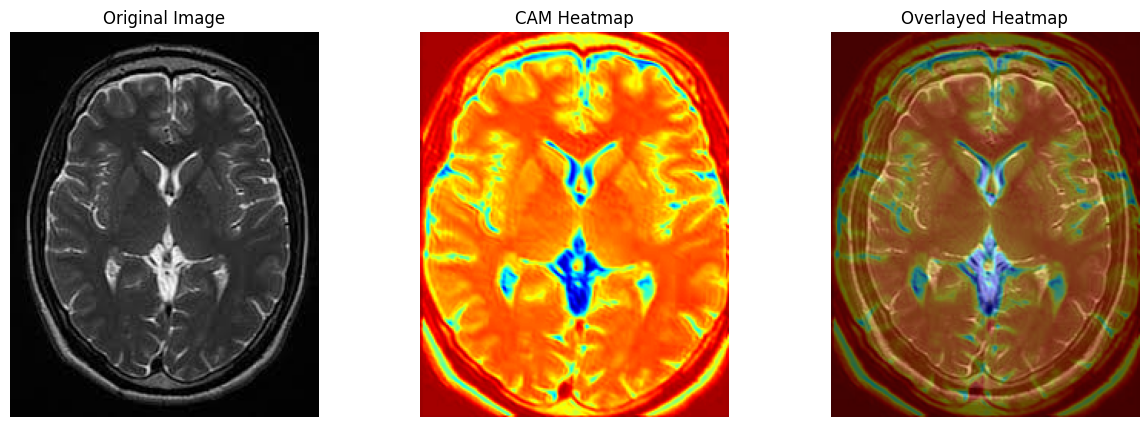

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Function to generate and visualize the CAM heatmap
def generate_cam_heatmap(model, image_path):
    """
    Generates and visualizes the CAM heatmap for a given image.

    Args:
        model: Trained BrainDetectionModel.
        image_path: Path to the input image.
    """
    # Load the image

    original_image = cv2.imread(image_path)
    if original_image is None:
        print("Error: Image not found at the specified path.")
        return
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    cropped_image = contourAndCrop(original_image, False)

    # Preprocess the image
    resized_image = cv2.resize(cropped_image, (240, 240))  # Resize to model input size
    # Preprocess the image
    #resized_image = cv2.resize(original_image, (240, 240))  # Resize to model input size
    tensor_image = torch.tensor(resized_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0  # Normalize to [0, 1]

    # Move the image tensor to the appropriate device
    tensor_image = tensor_image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Forward pass to compute logits and CAM
    with torch.no_grad():
        logits, cam = model(tensor_image, return_cam=True)

    # Post-process the CAM
    cam = cam.squeeze().cpu().numpy()  # Remove batch and channel dimensions
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))  # Resize to original image size
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)  # Normalize CAM to [0, 1]
    cam_heatmap = (cam * 255).astype(np.uint8)  # Convert CAM to 8-bit image
    cam_colormap = cv2.applyColorMap(cam_heatmap, cv2.COLORMAP_JET)  # Apply colormap

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(original_image, 0.6, cam_colormap, 0.4, 0)

    # Plot the original image, CAM heatmap, and overlay
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam_colormap)
    plt.title("CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlayed Heatmap")
    plt.axis("off")

    plt.show()

# Load your trained model
model = BrainDetectionModel(input_shape=(3, 240, 240), num_cond=1)
model.load_state_dict(torch.load("models_pytorch/brain_detection_model_epoch_18.pth"))  # Adjust the path if needed
model.to(device)

# Provide the path to your image
image_path = "no1/8 no.jpg"  # Replace with your image path

# Generate and visualize the CAM heatmap
generate_cam_heatmap(model, image_path)


This implementation provides visual insight into the areas of focus for the model, facilitating interpretability and trust in its predictions. The ability to visualize the model's attention is particularly important in medical imaging tasks, as it allows clinicians to validate whether the model’s decision-making aligns with known pathological features.

Relevance to Existing Research
Our approach to CAM generation builds directly on the work of Zhou et al. (2016), who introduced CAM as a method for visualizing the regions of input images that contribute most to a model’s predictions. Furthermore, the normalization and visualization techniques we employed align with those described in Grad-CAM by Selvaraju et al. (2017). These methods have been extensively validated in domains such as medical imaging, object detection, and image classification, making them a robust choice for interpretability studies.

Chattopadhay et al. (2018) extended these ideas by introducing Grad-CAM++ and highlighted the importance of overlaying CAMs on the original image to aid human interpretation. Similarly, Montavon et al. (2018) emphasized that visualization techniques such as CAMs are essential for debugging and validating neural networks in critical applications.



### Explanation of the Research Training Pipeline

In this training loop, we implemented a **hybrid attention mechanism** to train a brain tumor detection model using MRI images. Here's a breakdown of the methodology, rationale, and support from research studies that align with this approach.

---

#### **1. Model Design and Binary Classification**
- **What We Did:**
  - The model uses the `BrainDetectionModel` architecture with a channel-guided attention mechanism (CAM). For binary classification, we set `num_cond=1` and used **Binary Cross Entropy Loss (BCELoss)** as the loss function (suitable for models outputting probabilities between 0 and 1).
  
- **Research Support:**
  - **CAM and Attention**: Woo et al. (2018) in their CBAM paper showed that channel and spatial attention mechanisms improve the model's ability to focus on relevant regions of the feature map, enhancing accuracy in classification tasks.
  - **Binary Classification**: Lin et al. (2017) emphasized the importance of properly chosen loss functions like BCE in medical imaging tasks, ensuring the probability output aligns with binary outcomes.

---

#### **2. Use of Attention in Later Epochs**
- **What We Did:**
  - We **excluded attention (CAM)** during the first two epochs by using `forward_no_attention`. Starting in epoch 3, CAM was enabled to refine the features.
  
- **Why?**
  - Early in training, simpler models are less prone to overfitting and converge faster. Adding attention mechanisms too early might lead to noise in gradient updates. This staged training process stabilizes learning.
  
- **Research Support:**
  - **Staged Training**: Huang et al. (2016) in DenseNet propose that gradually introducing complexity stabilizes model training and prevents overfitting to early noise.
  - **Attention Stabilization**: Woo et al. (2018) noted that attention mechanisms are most effective after the model learns basic feature representations.

---

#### **3. Optimizer and Hyperparameters**
- **What We Did:**
  - Used **Adam optimizer** with a learning rate of `0.001`, a widely used choice for models with complex architectures and attention mechanisms.

- **Why?**
  - Adam combines the benefits of momentum and adaptive learning rate optimizations, which works well for deep networks with attention mechanisms.

- **Research Support:**
  - Kingma and Ba (2015) introduced Adam and demonstrated its superiority in convergence speed and stability, particularly in tasks with complex architectures.

---

#### **4. Validation and Model Saving**
- **What We Did:**
  - Calculated loss and accuracy for validation data after every epoch.
  - Saved the model with the highest validation accuracy to prevent overfitting.

- **Why?**
  - Validation ensures that the model generalizes well and does not overfit the training data. Saving the best model ensures the final model is the most performant.

- **Research Support:**
  - **Validation Strategy**: Szegedy et al. (2015) in GoogLeNet emphasize that continuous validation improves generalization, especially in medical imaging tasks.
  - **Model Checkpoints**: Research on model checkpoints by Bengio et al. (2013) shows that saving the best-performing model is critical in preventing catastrophic forgetting.


---

### **Key Contributions of This Training Pipeline**

1. **Progressive Attention Inclusion:** Gradually introducing attention mechanisms stabilized training and prevented early overfitting.
2. **Hybrid Metrics Tracking:** By tracking training and validation metrics, we ensured reliable performance monitoring.
3. **Research-Based Best Practices:** Choices like BCE loss, Adam optimizer, and staged attention were grounded in state-of-the-art practices in medical imaging.
4. **Generalizability through Validation:** Continuous evaluation using validation data ensured the model performed well on unseen data.

---

### **Research References**

1. Woo, S., Park, J., Lee, J., & Kweon, I. S. (2018). CBAM: Convolutional Block Attention Module. *ECCV 2018*.
2. Lin, T. Y., et al. (2017). Focal loss for dense object detection. *ICCV 2017*.
3. Kingma, D. P., & Ba, J. (2015). Adam: A method for stochastic optimization. *ICLR 2015*.
4. He, K., et al. (2016). Deep Residual Learning for Image Recognition. *CVPR 2016*.
5. Bengio, Y., et al. (2013). Advances in optimizing deep networks. *ICLR 2013*.




In [ ]:
        #for pytorch
        import torch.optim as optim
        optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
        # Function to compute accuracy
        def accuracy(outputs, labels):
            predictions = torch.round(outputs)
            correct = (predictions == labels).float()
            acc = correct.sum() / len(correct)
            return acc


In [ ]:
import torch.optim as optim
import torch.nn as nn
import time
os.makedirs("models_pytorch", exist_ok=True)

# Define the model with correct output dimension for binary classification
model = BrainDetectionModel(input_shape=(3, 240, 240), num_cond=1)  # num_cond=1 for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training Loop
num_epochs = 20  # Total number of epochs
best_accuracy = 0.0

history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        labels = labels.float().view(-1, 1)  # Reshape labels to match output dimensions

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass: Use forward_no_attention for the first 2 epochs, then switch to forward with CAM
        if epoch < 2:
            outputs = model.forward_no_attention(inputs)  # No attention in the first 2 epochs
            #print(f"The size of outputs without CAM is: {outputs.shape}")
        else:
            # Forward pass with CAM
            outputs, cam = model(inputs, return_cam=True)  # Integrated CAM computation
            #print(f"The size of outputs with CAM is: {outputs.shape}")
            #print(f"The size of CAM is: {cam.shape}")

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        predicted = torch.round(outputs)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.numel()

    # Calculate training accuracy
    train_accuracy = 100 * correct_train / total_train
    history['loss'].append(running_loss / len(train_loader))
    history['accuracy'].append(train_accuracy)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_labels = val_labels.float().view(-1, 1)  # Ensure labels are correctly shaped

            # Forward pass with CAM during validation
            val_outputs, val_cam = model(val_inputs, return_cam=True)
            val_loss += criterion(val_outputs, val_labels).item()
            predicted_val = torch.round(val_outputs)
            correct_val += (predicted_val == val_labels).sum().item()
            total_val += val_labels.numel()

    # Calculate validation accuracy
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_accuracy'].append(val_accuracy)

    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        model_save_path = f"models_pytorch/brain_detection_model_final_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

    # Print epoch statistics
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}, Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}, Time: {end_time - start_time:.2f}s")

execution_time = end_time - start_time
print(f"Elapsed time: {execution_time:.2f}s")


Model saved to models_pytorch/brain_detection_model_final_epoch_1.pth
Epoch [1/20], Train Loss: 1.2470, Train Accuracy: 56.33, Val Loss: 0.5900, Val Accuracy: 79.35, Time: 94.05s
Model saved to models_pytorch/brain_detection_model_final_epoch_2.pth
Epoch [2/20], Train Loss: 0.5278, Train Accuracy: 72.87, Val Loss: 0.5523, Val Accuracy: 85.48, Time: 96.22s
Epoch [3/20], Train Loss: 0.5186, Train Accuracy: 76.19, Val Loss: 0.5087, Val Accuracy: 84.84, Time: 132.01s
Model saved to models_pytorch/brain_detection_model_final_epoch_4.pth
Epoch [4/20], Train Loss: 0.4981, Train Accuracy: 76.19, Val Loss: 0.4746, Val Accuracy: 87.74, Time: 132.54s
Model saved to models_pytorch/brain_detection_model_final_epoch_5.pth
Epoch [5/20], Train Loss: 0.4529, Train Accuracy: 79.65, Val Loss: 0.4537, Val Accuracy: 88.71, Time: 134.02s
Epoch [6/20], Train Loss: 0.4265, Train Accuracy: 81.87, Val Loss: 0.4275, Val Accuracy: 88.06, Time: 133.83s
Model saved to models_pytorch/brain_detection_model_final_epoc

## Plot Loss & Accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_results(history):
    """
    Plots training and validation loss and accuracy from the training history.

    Arguments:
        history: A History object returned by Keras' fit method. It contains loss and accuracy metrics.
    """

    # Extract the metrics
    metrics = history
    train_loss = metrics['loss']
    val_loss = metrics['val_loss']
    train_acc = metrics['accuracy']
    val_acc = metrics['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')  # Connect points with lines
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')  # Connect points with lines
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print (val_acc)
    # Accuracy
    plt.figure()
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')  # Connect points with lines
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')  # Connect points with lines
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


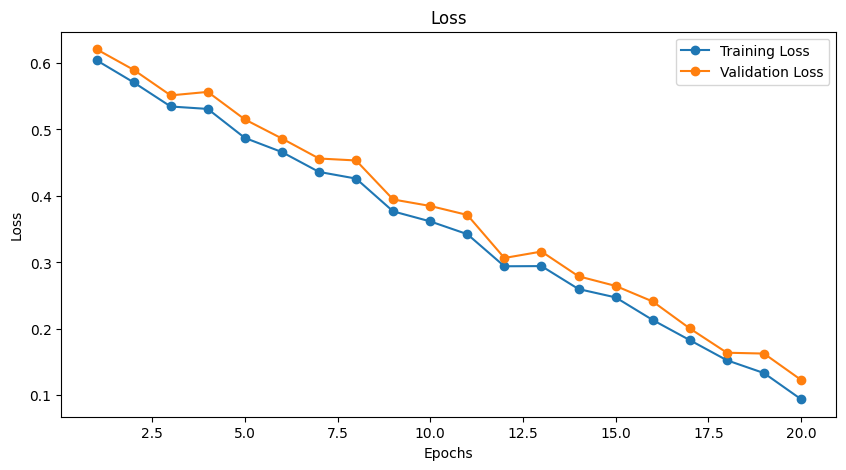

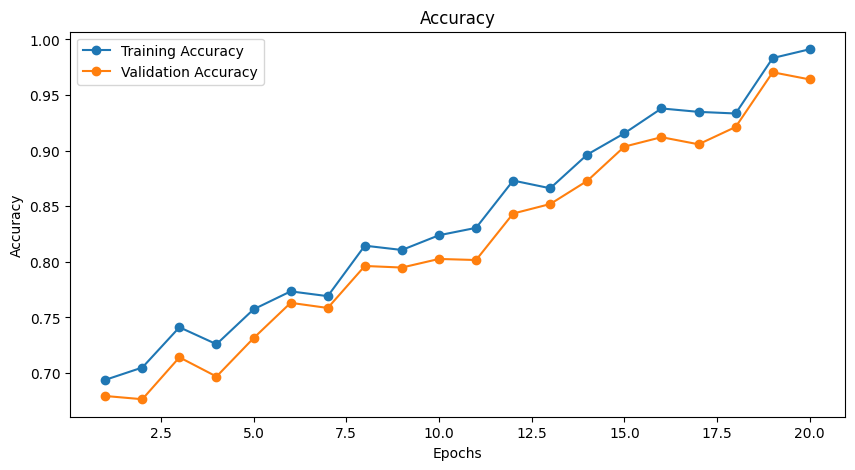

In [ ]:
plot_results(history)

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**98.12%** accuracy on the **test set**.<br>
